In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import itertools
import pickle
from skimage.segmentation import mark_boundaries
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import os
import contextlib

c:\Users\prabh\anaconda3\envs\py\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.__version__

'2.14.0'

In [2]:
test_dataset = tf.data.Dataset.load('E:/UnderSpec/main/test_dataset')

batch_size = 64
test_dataset = test_dataset.shuffle(batch_size)

(64, 32, 32, 3)
(64, 10)
Normalized values:  (0.0, 0.99534315)


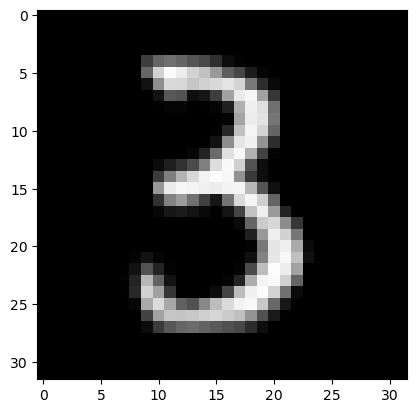

In [3]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img = np.array(img_batch)
    print('Normalized values: ', (np.min(img_batch[0]), np.max(img_batch[0])))
    plt.imshow(img[0])

# load models

In [4]:
cnn = tf.keras.models.load_model("E:/UnderSpec/main/mnist/models/std/cnn_mnist_std.h5")
resnet = tf.keras.models.load_model("E:/UnderSpec/main/mnist/models/std/resnet_mnist_std.h5")
densenet = tf.keras.models.load_model("E:/UnderSpec/main/mnist/models/std/densenet_mnist_std.h5")

In [5]:
_, acc = cnn.evaluate(test_dataset)

14/14 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9888


In [9]:
cnn._name = 'cnn_std'
resnet._name = 'ResNet50_std'
densenet._name = 'DenseNet121_std'

model_list = [cnn, resnet, densenet]

1/1 [==============================] - 0s 16ms/step
cnn_std: Predicted as : 7
1/1 [==============================] - 0s 14ms/step
ResNet50_std: Predicted as : 7
1/1 [==============================] - 0s 20ms/step
DenseNet121_std: Predicted as : 7


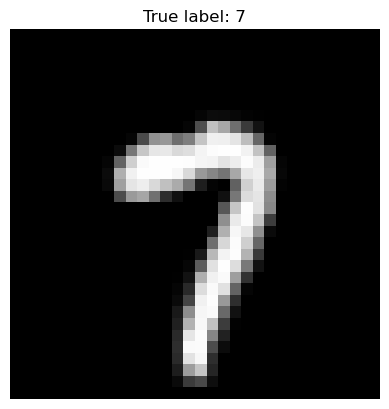

In [10]:
img_batch, label_batch = next(iter(test_dataset))

test_img = img_batch[2]


plt.imshow(test_img)
plt.title(f'True label: {np.argmax(label_batch[2])}')
plt.axis('off')

for model in model_list:
    pred = model.predict(np.array(test_img).reshape(-1,32,32,3))
    print(f"{model._name}: Predicted as : {np.argmax(pred)}")

>>>>>>>>>>>>>>>>>>>>>>>>>>>> LIME Explanations

In [11]:
"""Prediction wrapper function to pass to LIME explainer"""

def prediction_fn(images, model):
    images = np.array(images)

    if len(images.shape) == 3:  # Single image case
        images = images.reshape(-1, 32, 32, 3)
    elif len(images.shape) == 4:  # Batch case
        if images.shape[1:] != (32, 32, 3):
            raise ValueError("Expected images with shape (32, 32, 3)")

    # Get predictions
    predictions = model.predict(images, verbose=0)

    return predictions

In [12]:
""" LIME Image Explainer """
segmenter_quick = SegmentationAlgorithm("slic", kernal_size=3) 

explainer = lime_image.LimeImageExplainer(verbose=False, random_state =42)

#LIME function
def explain_aninstance(image, model, no_of_samples):
    with open(os.devnull, 'w') as f:
        with contextlib.redirect_stdout(f):
            explanation = explainer.explain_instance(image,
                                                    lambda x: prediction_fn(x, model),
                                                    #lime_prediction_fn,
                                                    top_labels = 3,
                                                    hide_color = 0,
                                                    # random_state= 42,
                                                    num_samples = no_of_samples,
                                                    segmentation_fn=segmenter_quick
                                                            )
            
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                        positive_only=True,
                                                        num_features=5,
                                                        hide_rest=True)
            
            img_boundry = mark_boundaries(temp, mask) if temp.dtype == 'double' else mark_boundaries(temp, mask)

            return img_boundry, temp, mask

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> For Standard Models

100%|██████████| 1000/1000 [00:07<00:00, 126.15it/s]


1/1 [==============================] - 0s 25ms/step


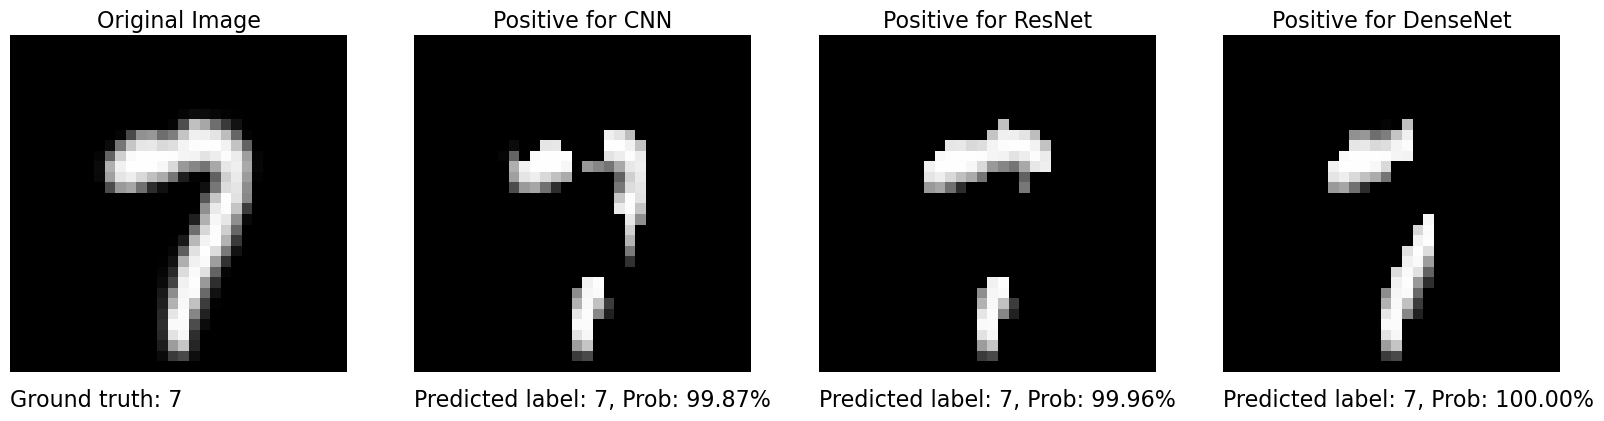

In [84]:
test_img = np.array(test_img)

_, temp_cnn, _ = explain_aninstance(test_img, cnn, no_of_samples=1000)
_, temp_res, _ = explain_aninstance(test_img, resnet, no_of_samples=1000)
_, temp_dense, _ = explain_aninstance(test_img, densenet, no_of_samples=1000)

expl_list = [temp_cnn,  temp_res, temp_dense]
sample_label = "7"

plt.figure(figsize=(20,12))

plt.subplot(1,4,1)
plt.imshow(test_img)
plt.title('Original Image',fontsize=16)
plt.text(0, -0.1,f'Ground truth: {sample_label}', fontsize=16, transform=plt.gca().transAxes)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(temp_cnn)
plt.title(f"Positive for CNN", fontsize=16)
plt.text(0, -0.1, 
         f'Predicted label: {np.argmax(cnn.predict(test_img.reshape(-1,32,32,3)))}, Prob: {np.max(cnn.predict(test_img.reshape(-1,32,32,3)))*100:.2f}%',
         fontsize=16, 
         transform=plt.gca().transAxes)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(temp_res)
plt.title(f'Positive for ResNet', fontsize=16)
plt.text(0, -0.1, 
         f'Predicted label: {np.argmax(resnet.predict(test_img.reshape(-1,32,32,3)))}, Prob: {np.max(resnet.predict(test_img.reshape(-1,32,32,3)))*100:.2f}%',
         fontsize=16, 
         transform=plt.gca().transAxes)
plt.axis('off') 

plt.subplot(1,4,4)
plt.imshow(temp_dense)
plt.title(f'Positive for DenseNet', fontsize=16)
plt.text(0, -0.1, 
         f'Predicted label: {np.argmax(densenet.predict(test_img.reshape(-1,32,32,3)))}, Prob: {np.max(densenet.predict(test_img.reshape(-1,32,32,3)))*100:.2f}%',
         fontsize=16, 
         transform=plt.gca().transAxes)
plt.axis('off')

plt.show()

In [85]:
flattened_explanations = []

for expl in expl_list:
    flattened_explanations.append(expl.flatten())

In [59]:
flattened_explanations

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [78]:
def distance_matrix(temp):
    distance_matrix = np.zeros((len(temp), len(temp)))

    for i in range(len(temp)):
        for j in range(len(temp)):
            if i !=j:
                distance_matrix[i, j] = np.abs(np.round(1 - cosine_similarity(temp[i].reshape(1,-1), temp[j].reshape(1,-1)), decimals=4))
            
    return distance_matrix

C:\Users\prabh\AppData\Local\Temp\ipykernel_41148\1391006186.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance_matrix[i, j] = np.abs(np.round(1 - cosine_similarity(temp[i].reshape(1,-1), temp[j].reshape(1,-1)), decimals=4))
C:\Users\prabh\AppData\Local\Temp\ipykernel_41148\1391006186.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distance_matrix[i, j] = np.abs(np.round(1 - cosine_similarity(temp[i].reshape(1,-1), temp[j].reshape(1,-1)), decimals=4))
C:\Users\prabh\AppData\Local\Temp\ipykernel_41148\1391006186.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.

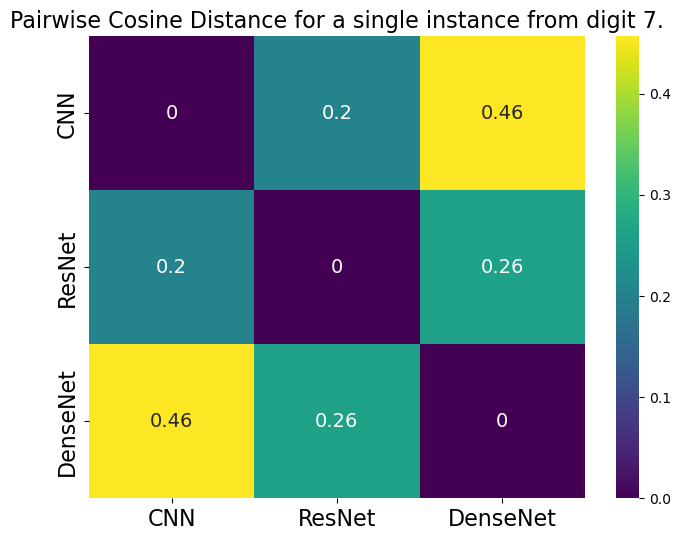

In [86]:
dis_matrix_std = distance_matrix(flattened_explanations)

#plot the dissimilarity matrix as a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(dis_matrix_std, 
            annot=True,
            cmap='viridis',
            xticklabels=['CNN', 'ResNet', 'DenseNet'], 
            yticklabels=['CNN', 'ResNet', 'DenseNet'],
            annot_kws={"size":14}
            )

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Pairwise Cosine Distance for a single instance from digit 7.', fontsize=16)
plt.show()

>>>>>>>>>>>>>>>>>>>>>>>>> Explaining multiple instances (Class Perspective)

In [64]:
def get_sample(class_index, dataset):
    sample_list = []
    for images, labels in dataset.unbatch():
        if np.argmax(labels, axis=0) == class_index: #labels are categorical
            sample_list.append((images, labels))
            
            # if len(sample_list) == num_of_samples:
            #     break

    return sample_list

In [65]:
sample_list_7 = get_sample(class_index=7,
                           dataset=test_dataset,)

In [66]:
len(sample_list_7)

95

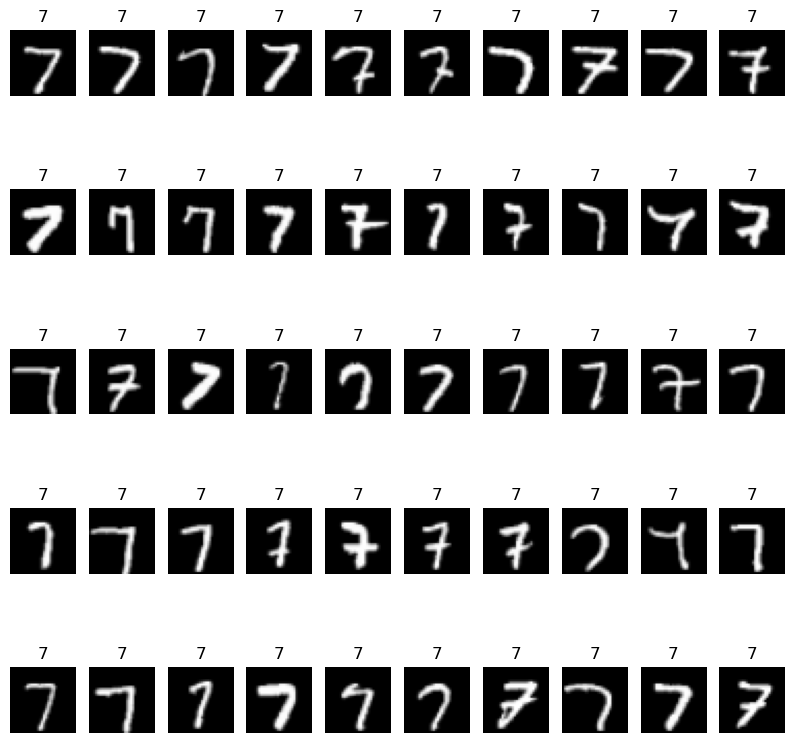

In [76]:
plt.figure(figsize=(10,10))

for index, (image, label) in enumerate(sample_list_7[:50]):
    plt.subplot(5,10, index + 1)
    plt.imshow(image.numpy().astype('double'))
    plt.title(7)
    plt.axis('off')

In [77]:
def get_predictions(models, dataset):
    predictions = []
    index = 0

    for images, labels in dataset:
        #flag
        correct = True
        for model in models:
            pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
            pred_label = np.argmax(pred, axis=-1)
            true_label = np.argmax(labels.numpy(), axis=-1)

            if pred_label != true_label:
                correct = False
                break

        if not correct:
            print(f"Wrong Prediction at index {index} by {model.name}: Predicted {pred_label}, True {true_label}")
            
        predictions.append((images, labels, correct))
        index +=1

    return predictions

def filter_correct_predictions(predictions):
   return [(image, label) for image, label, correct in predictions if correct]

In [13]:
predictions = get_predictions(model_list, sample_list_7)

In [79]:
new_sample_list_7 = filter_correct_predictions(predictions)

In [80]:
len(new_sample_list_7)

92

In [81]:
# create a LimeImageExplainer
explainer = lime_image.LimeImageExplainer(verbose=False, random_state =42)

def explanation_fn(instance_list, model, num_of_perturbations):

    explanation_list = []

    for idx, (image, label) in enumerate(instance_list):
        
        print("Iteration :", idx+1)

        img = np.array(image)
        img = img.astype('double')

        explanation = explainer.explain_instance(img,
                                            lambda x: prediction_fn(x, model),
                                            top_labels=5, 
                                            hide_color=0,
                                            segmentation_fn=segmenter_quick,
                                            num_samples=num_of_perturbations)
        print(f"Predicted Class : {np.argmax(prediction_fn(image, model))}")
        print(f"Explaining Class: {explanation.top_labels[0]}")

        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                    positive_only=True, 
                                                    num_features=5, 
                                                    hide_rest=True)

        explanation_list.append(temp)

    return explanation_list

In [82]:
"""Checking if everything is fine"""

test_explain = explanation_fn(new_sample_list_7[:3], cnn, 300)

Iteration : 1


100%|██████████| 300/300 [00:01<00:00, 289.92it/s]


Predicted Class : 7
Explaining Class: 7
Iteration : 2


100%|██████████| 300/300 [00:01<00:00, 294.22it/s]


Predicted Class : 7
Explaining Class: 7
Iteration : 3


100%|██████████| 300/300 [00:01<00:00, 291.77it/s]


Predicted Class : 7
Explaining Class: 7


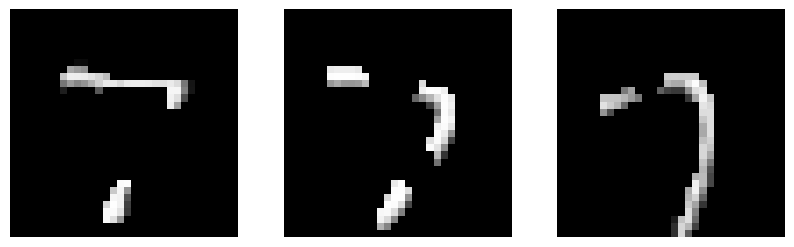

In [83]:
plt.figure(figsize=(10,10))

for index, temp in enumerate(test_explain):
    plt.subplot(1,3, index + 1)
    plt.imshow(temp)
    plt.axis('off')

In [84]:
%%time
with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        explain_7_cnn = explanation_fn(new_sample_list_7, cnn, 1000)
        explain_7_resnet = explanation_fn(new_sample_list_7, resnet, 1000)
        explain_7_densenet = explanation_fn(new_sample_list_7, densenet, 1000)
        # explain_7_mlp = explanation_fn(new_sample_list_7, mlp, 1000)
        # explain_7_mobilenet = explanation_fn(new_sample_list_7, mobilenet, 1000)

100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


CPU times: total: 1h 34min 26s
Wall time: 10h 11min 40s


In [1]:
# """Save the explanations for the future use"""

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\cnn_std_expl7.pkl", 'wb') as file:
#     pickle.dump(explain_7_cnn, file)

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\mlp_std_expl7.pkl", 'wb') as file:
#     pickle.dump(explain_7_mlp, file)

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\mobilenet_std_expl7.pkl", 'wb') as file:
#     pickle.dump(explain_7_mobilenet, file)

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp/resnet_std_expl7.pkl", 'wb') as file:
#     pickle.dump(explain_7_resnet, file)

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\densenet_std_expl7.pkl", 'wb') as file:
#     pickle.dump(explain_7_densenet, file)

In [68]:
""" load the explanations """
with open("E:/UnderSpec/main/mnist/LIME Explanations/std_exp\cnn_std_expl7.pkl", 'rb') as file:
    cnn_expl7 = pickle.load(file)

with open("E:/UnderSpec/main/mnist/LIME Explanations/std_exp/resnet_std_expl7.pkl", 'rb') as file:
    resnet_expl7 = pickle.load(file)

with open("E:/UnderSpec/main/mnist/LIME Explanations/std_exp/densenet_std_expl7.pkl", 'rb') as file:
    densenet_expl7 = pickle.load(file)


# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\mlp_std_expl7.pkl", 'rb') as file:
#     mlp_std_expl7 = pickle.load(file)

# with open("E:\Research\pretrained\mnist\LIME Explanations\std_exp\mobilenet_std_expl7.pkl", 'rb') as file:
#     mobilenet_std_expl7 = pickle.load(file)

Mean distance score between CNN and ResNet: 0.2955
Mean distance score between CNN and DenseNet: 0.2983
Mean distance score between ResNet and DenseNet: 0.3689


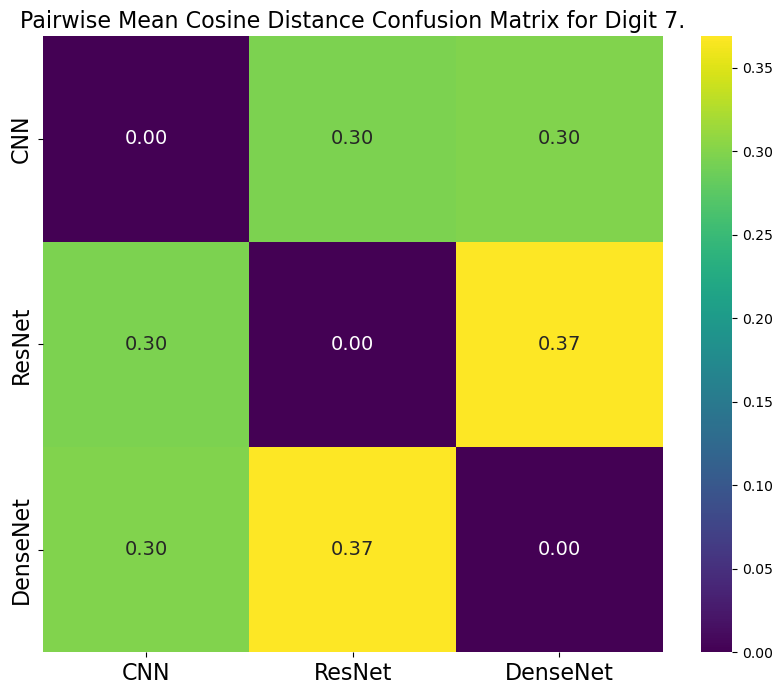

In [76]:
explanations_list = [cnn_expl7, resnet_expl7, densenet_expl7]
model_names = ['CNN', 'ResNet', 'DenseNet']

pairwise_cosine_distance = {}
num_models = len(model_names)
distance_matrix = np.zeros((num_models, num_models))


for (i, expl_list1), (j, expl_list2) in itertools.combinations(enumerate(explanations_list),2):
    cosine_distances = []

    for expl1, expl2 in zip(expl_list1, expl_list2):
        expl1_flat = expl1.flatten().reshape(1,-1)
        expl2_flat = expl2.flatten().reshape(1,-1)

        sim = cosine_similarity(expl1_flat, expl2_flat)[0][0]
        dist = 1 - sim
        cosine_distances.append(dist)

    model_pair = (model_names[i], model_names[j])
    mean_distance = np.mean(cosine_distances)
    pairwise_cosine_distance[model_pair] = mean_distance
    distance_matrix[i,j] = mean_distance
    distance_matrix[j, i] = mean_distance

for model_pair, mean_dis in pairwise_cosine_distance.items():
    print(f"Mean distance score between {model_pair[0]} and {model_pair[1]}: {mean_dis:.4f}")

np.fill_diagonal(distance_matrix, 0)
plt.figure(figsize=(10,8))
sns.heatmap(distance_matrix, 
            annot=True, 
            
            fmt=".2f",
            cmap="viridis",
            xticklabels=model_names,
            yticklabels=model_names,
            annot_kws={"size":14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Pairwise Mean Cosine Distance Confusion Matrix for Digit 7.', fontsize=16)
plt.show()

In [70]:
#check if the above output is correct
cosine_similarities = []

for expl_cnn, expl_mlp in zip(cnn_expl7, resnet_expl7):
    expl_cnn_flat = expl_cnn.flatten().reshape(1, -1)
    expl_mlp_flat = expl_mlp.flatten().reshape(1, -1)

    sim = cosine_similarity(expl_cnn_flat, expl_mlp_flat)[0][0]
    cosine_similarities.append(sim)

mean_similarity = np.mean(cosine_similarities)
model_pair = (model_names[0], model_names[1])
print(f"\nMean cosine similarity between {model_pair[0]} and {model_pair[1]}: {mean_similarity:.4f}")


Mean cosine similarity between CNN and ResNet: 0.7045


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>